In [1]:
# Import all the libraries 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.applications.efficientnet import EfficientNetB7
from keras.applications.efficientnet import preprocess_input
import pandas as pd
import pathlib

2024-03-11 10:01:31.859829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 10:01:31.859919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 10:01:31.992690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_model = keras.applications.EfficientNetB7(include_top=False, input_shape=(600, 600, 3))

base_model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "efficientnetb7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 600, 600,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 600, 600,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 600, 600,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 600, 600,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 601, 601,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 300, 300,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 300, 300,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 300, 300,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 300, 300,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 300, 300,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 300, 300,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 300, 300,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 300, 300,  │      2,048 │ block1a_se_excit

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [3]:
base_model.trainable = False #so the model does not lose properties in the training

In [4]:
# Create inputs with correct shape
inputs = keras.Input(shape=(600,600,3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(5, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs,outputs)

In [5]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 600, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        12,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,110,492 (244.56 MB)

 Trainable params: 12,805 (50.02 KB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [6]:
model.compile(loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [7]:
train_data_dir = pathlib.Path("train/")
batch_size = 32
img_height = 600
img_width = 600
data_dir = "/kaggle/input/ecg-images/ecg_img/train"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 37178 files belonging to 5 classes.
Using 29743 files for training.


In [8]:
43691/54613

0.8000109863951806

In [9]:
class_names = train_ds.class_names
class_names

['F', 'N', 'Q', 'S', 'V']

In [10]:
# Initialize dictionaries to store the counts for each class
class_counts_training = {class_name: 0 for class_name in class_names}

# Iterate through the training dataset to count the samples for each class
for images, labels in train_ds:
    for label in labels:
        class_counts_training[class_names[label]] += 1

# Print the counts for each class in the training set
print("Training set class counts:")
for class_name, count in class_counts_training.items():
    print(f"{class_name}: {count}")

Training set class counts:
F: 516
N: 17626
Q: 5161
S: 1782
V: 4658


In [11]:
import numpy as np
sum(np.array([516,
17626,
5161,
1782,
4658]))

29743

80% for training and 20% for testing

# Validation:

In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 37178 files belonging to 5 classes.
Using 7435 files for validation.


In [13]:
# Initialize dictionaries to store the counts for each class in the validation set
class_counts_validation = {class_name: 0 for class_name in class_names}

# Iterate through the validation dataset to count the samples for each class
for images, labels in val_ds:
    for label in labels:
        class_counts_validation[class_names[label]] += 1

# Print the counts for each class in the validation set
print("\nValidation set class counts:")
for class_name, count in class_counts_validation.items():
    print(f"{class_name}: {count}")


Validation set class counts:
F: 125
N: 4496
Q: 1252
S: 440
V: 1122


# Data Augmentation and Analysis

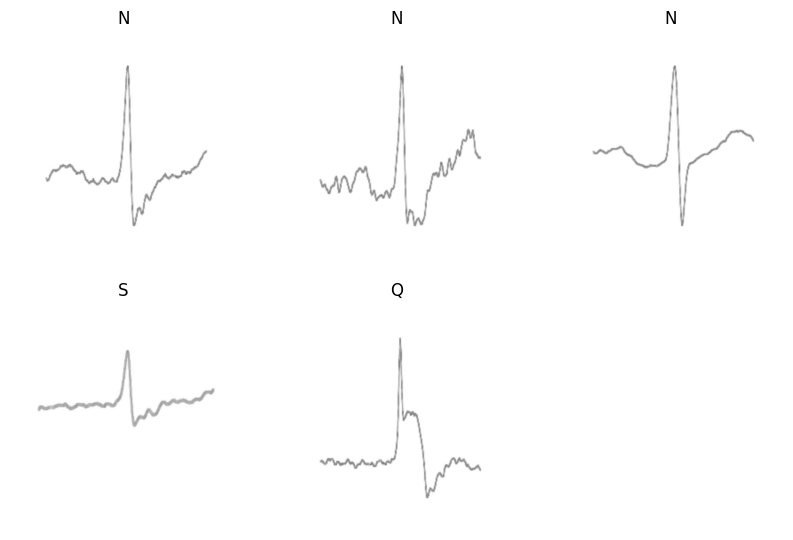

In [14]:
# Plot the first batch of images
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(len(class_names)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

    plt.show()

In [15]:
print(train_ds.element_spec)#3 filters

(TensorSpec(shape=(None, 600, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [16]:
# Create an ImageDataGenerator for augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #samplewise_center=True,
    rotation_range=2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,#makes no sense to be true
    fill_mode='nearest',
    validation_split=0.2
)



In [17]:
# Create the data generator for augmentation
train_datagen = datagen.flow_from_directory(
    data_dir,
    subset="training",
    seed=123,
    color_mode='rgb',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Specify class_mode as 'categorical' for one-hot encoded labels
)


Found 29744 images belonging to 5 classes.


In [18]:
print(train_datagen.target_size)#3 filters

(600, 600)


Transformed Images

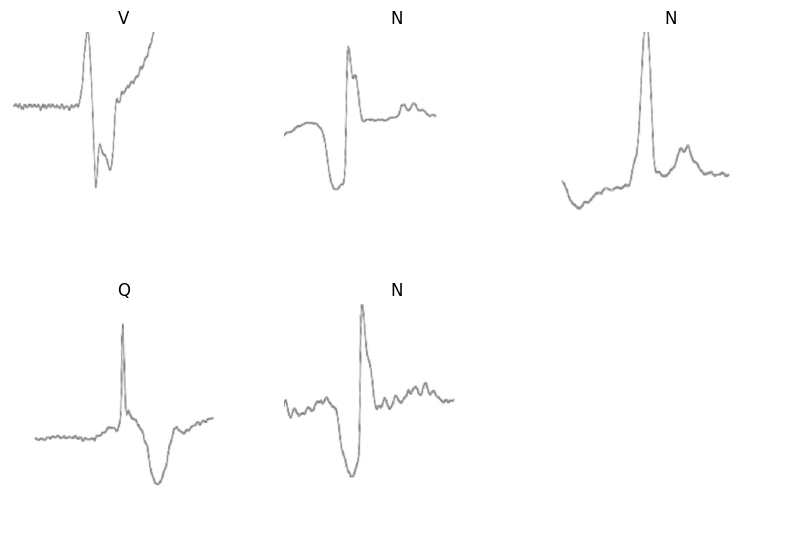

In [19]:

for images, labels in train_datagen:
    plt.figure(figsize=(10, 10))
    for i in range(len(class_names)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])  # Use tf.argmax to convert one-hot label to class name
        plt.axis("off")

    plt.show()
    break  # Break the loop after one batch for demonstration purposes

In [20]:
validation_generator = datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation') # set as validation data

Found 7434 images belonging to 5 classes.


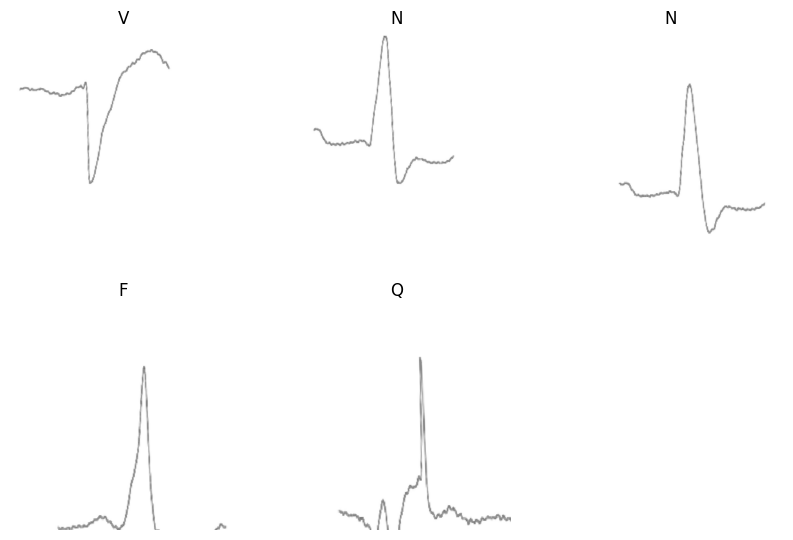

In [21]:

for images, labels in validation_generator:
    plt.figure(figsize=(10, 10))
    for i in range(len(class_names)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])  # Use tf.argmax to convert one-hot label to class name
        plt.axis("off")

    plt.show()
    break  # Break the loop after one batch for demonstration purposes

# Model Training

In [22]:
train_datagen.samples

29744

In [23]:
validation_generator.samples

7434

In [24]:
tf.random.set_seed(11)

In [25]:
train_datagen.samples//train_datagen.batch_size

929

In [26]:
model.fit(train_datagen,
          validation_data=validation_generator,
          steps_per_epoch=train_datagen.samples//train_datagen.batch_size,
          validation_steps=validation_generator.samples//validation_generator.batch_size,
          epochs=20,
         verbose = 1)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-11 10:07:14.231843: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,64,300,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,300,300]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-11 10:07:15.477268: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.245509777s
Tryin

431/929 ━━━━━━━━━━━━━━━━━━━━ 18:06 2s/step - accuracy: 0.8445 - loss: 0.5012

2024-03-11 10:25:47.684723: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k5=1,k6=0,k7=1,k10=1} for conv (f32[16,64,300,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,300,300]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-11 10:25:47.816102: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.131467109s
Trying algorithm eng12{k5=1,k6=0,k7=1,k10=1} for conv (f32[16,64,300,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,300,300]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyr

929/929 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8844 - loss: 0.3854

W0000 00:00:1710153935.855257     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


929/929 ━━━━━━━━━━━━━━━━━━━━ 2921s 3s/step - accuracy: 0.8845 - loss: 0.3853 - val_accuracy: 0.6005 - val_loss: 1.0831
Epoch 2/20
  1/929 ━━━━━━━━━━━━━━━━━━━━ 27:56 2s/step - accuracy: 0.9062 - loss: 0.3760

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1710154481.679177     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


929/929 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.9062 - loss: 0.3760 - val_accuracy: 0.6000 - val_loss: 1.3476
Epoch 3/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 2529s 3s/step - accuracy: 0.9613 - loss: 0.1396 - val_accuracy: 0.7209 - val_loss: 0.9254
Epoch 4/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 648us/step - accuracy: 0.9375 - loss: 0.1705 - val_accuracy: 0.6000 - val_loss: 1.6368
Epoch 5/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 2596s 3s/step - accuracy: 0.9673 - loss: 0.1139 - val_accuracy: 0.6211 - val_loss: 1.1703
Epoch 6/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 641us/step - accuracy: 0.9688 - loss: 0.1135 - val_accuracy: 0.5000 - val_loss: 1.0851
Epoch 7/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 2659s 3s/step - accuracy: 0.9717 - loss: 0.1033 - val_accuracy: 0.6721 - val_loss: 1.0843
Epoch 8/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 646us/step - accuracy: 1.0000 - loss: 0.0574 - val_accuracy: 0.6000 - val_loss: 0.8406
Epoch 9/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 2586s 3s/step - accuracy: 0.9731 - loss: 0.0934 - val_accurac

<Axes: >

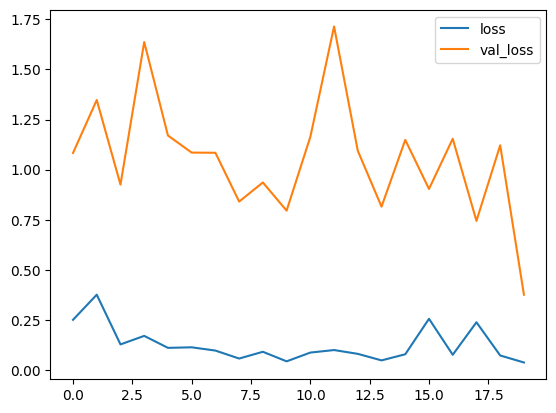

In [27]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

<Axes: >

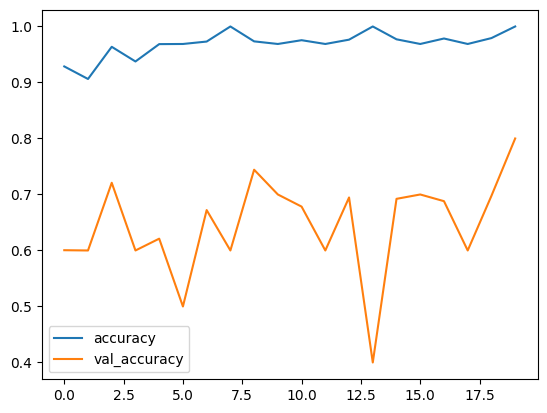

In [28]:
losses[['accuracy','val_accuracy']].plot()

In [32]:
y_pred = model.predict(validation_generator, verbose =1)
y_test = validation_generator.classes

233/233 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step


In [44]:
y_pred = np.argmax(y_pred, axis=-1)

In [54]:
np.unique(y_pred)

array([0, 1, 2, 3, 4])

In [57]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       128
           1       0.60      0.48      0.53      4424
           2       0.16      0.10      0.12      1282
           3       0.06      0.05      0.05       444
           4       0.15      0.35      0.21      1156

    accuracy                           0.36      7434
   macro avg       0.20      0.20      0.19      7434
weighted avg       0.41      0.36      0.37      7434



In [ ]:
print('ROC AUC SCORE',metrics.roc_auc_score(y_test,y_pred))
print('AP SCORE',metrics.average_precision_score(y_test,y_pred))

In [ ]:
#model.save("/kaggle/working/modelo/model_dfake-face.h5") 